In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import ml_cca

In [2]:
good_files =[2,3,6,7,8,9,11,12,13,17,19,21,22,24,27,33,36,38,
                     40,41,42,45,46,52,54,56,61,64,65,68,69,70,71,74,76,80,82,84,88,89,90,91,95]

In [3]:
n_voxels = 91*109*91
T1_data = np.zeros((len(good_files),n_voxels))
fMRI_data = np.zeros((len(good_files),n_voxels))

# Load the data

In [4]:
k = 0
for i in good_files:
    in_file = "/RDSMount/STUDY_DATA/SMART_DATA/HARRISON_WORK/T1standardBL/SMART0%02dT1_BL_brain_flirt.nii.gz" %i
    img = nib.load(in_file)
    data = img.get_data()
    T1_data[k] = data.flatten()
    k = k+1
T1_data = T1_data.astype('float32')

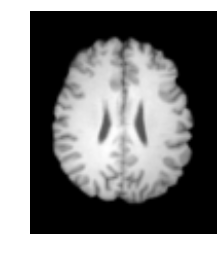

In [5]:
in_file = "/RDSMount/STUDY_DATA/SMART_DATA/HARRISON_WORK/T1standardBL/SMART070T1_BL_brain_flirt.nii.gz"
img = nib.load(in_file)
data = img.get_data()
plt.imshow(np.rot90(data[:,:,50]), 
               cmap="gray")
plt.gca().set_axis_off()

In [6]:
k = 0
for i in good_files:
    in_file = "/RDSMount/STUDY_DATA/SMART_DATA/HARRISON_WORK/func2standardBL/SMART0%02drsfMRI_BL_brain_mcf_flirt.nii.gz" %i
    img = nib.load(in_file)
    data = img.dataobj[...,100]
    fMRI_data[k] = data.flatten()
    k = k+1
fMRI_data = fMRI_data.astype('float32')

In [150]:
# Split the data to training and 'test' sets
fMRI_data_train = fMRI_data[0:42]
fMRI_data_test = fMRI_data[-1]
T1_data_train = T1_data[0:42]
T1_data_test = T1_data[-1]

## Perform PCA to reduce dimensionality

In [151]:
from sklearn.decomposition import PCA

In [152]:
T1_pca = PCA(n_components =10,whiten=True,svd_solver='randomized')

In [153]:
T1_data_reduced = T1_pca.fit_transform(T1_data_train)

In [154]:
fmri_pca = PCA(n_components =10,whiten=True,svd_solver='randomized')

In [155]:
fMRI_data_reduced = fmri_pca.fit_transform(fMRI_data_train)

## Plot the eigenvalues of PCA

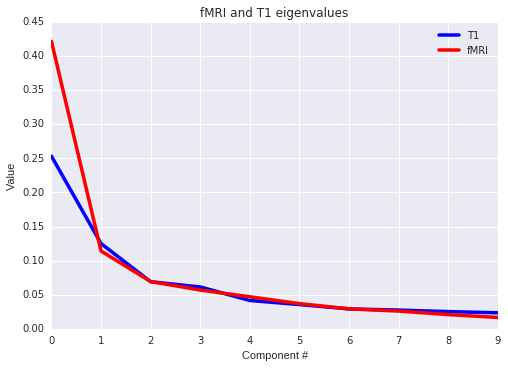

In [156]:
t = range(0,10)
line1, = plt.plot(t,T1_pca.explained_variance_ratio_,'b',label = 'T1',linewidth = 3.5)
line2, = plt.plot(t,fmri_pca.explained_variance_ratio_, 'r',label = 'fMRI',linewidth=3.5)
plt.title('fMRI and T1 eigenvalues')
plt.xlabel('Component #')
plt.ylabel('Value')
plt.legend(handles=[line1,line2])

In [157]:
import seaborn as sns
import pandas as pd

## Plot dimensions of dat against each other

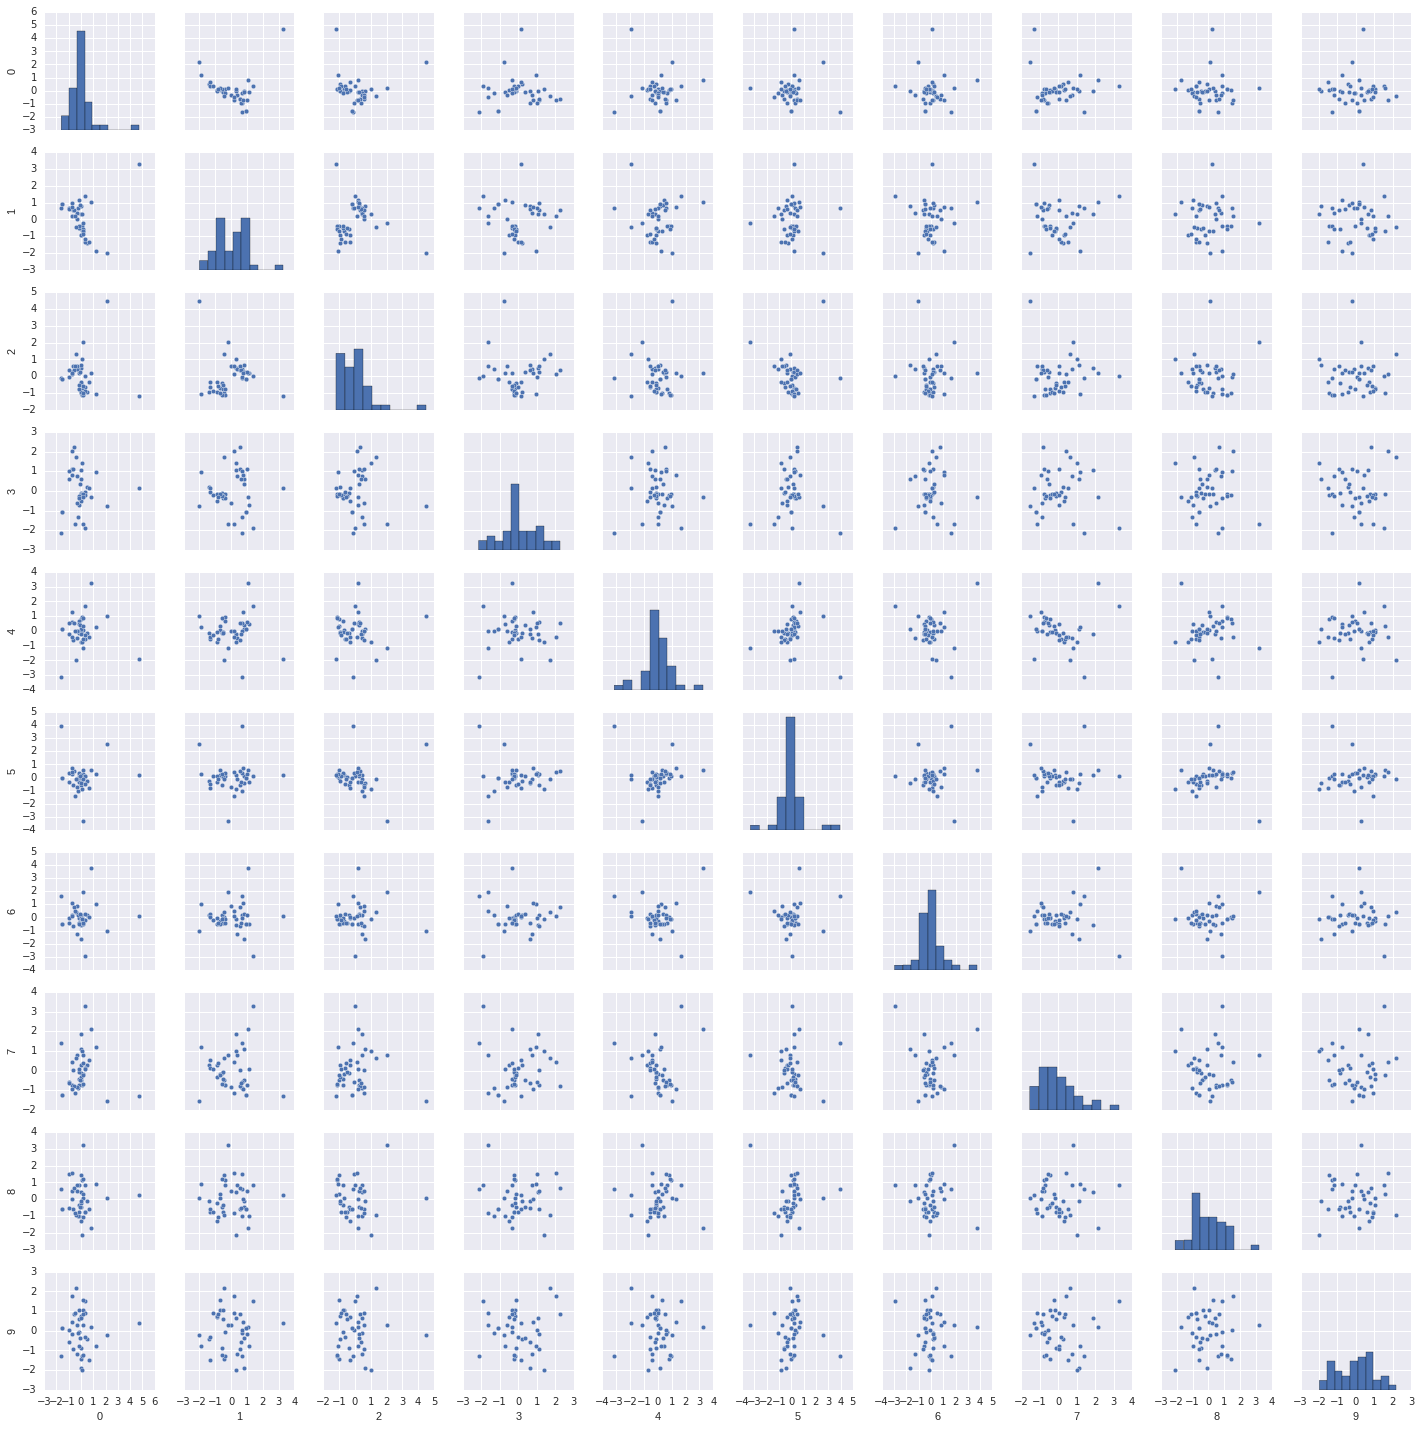

In [158]:
#fmri data
df = pd.DataFrame(fMRI_data_reduced)
sns.pairplot(df,size = 2, aspect=1)

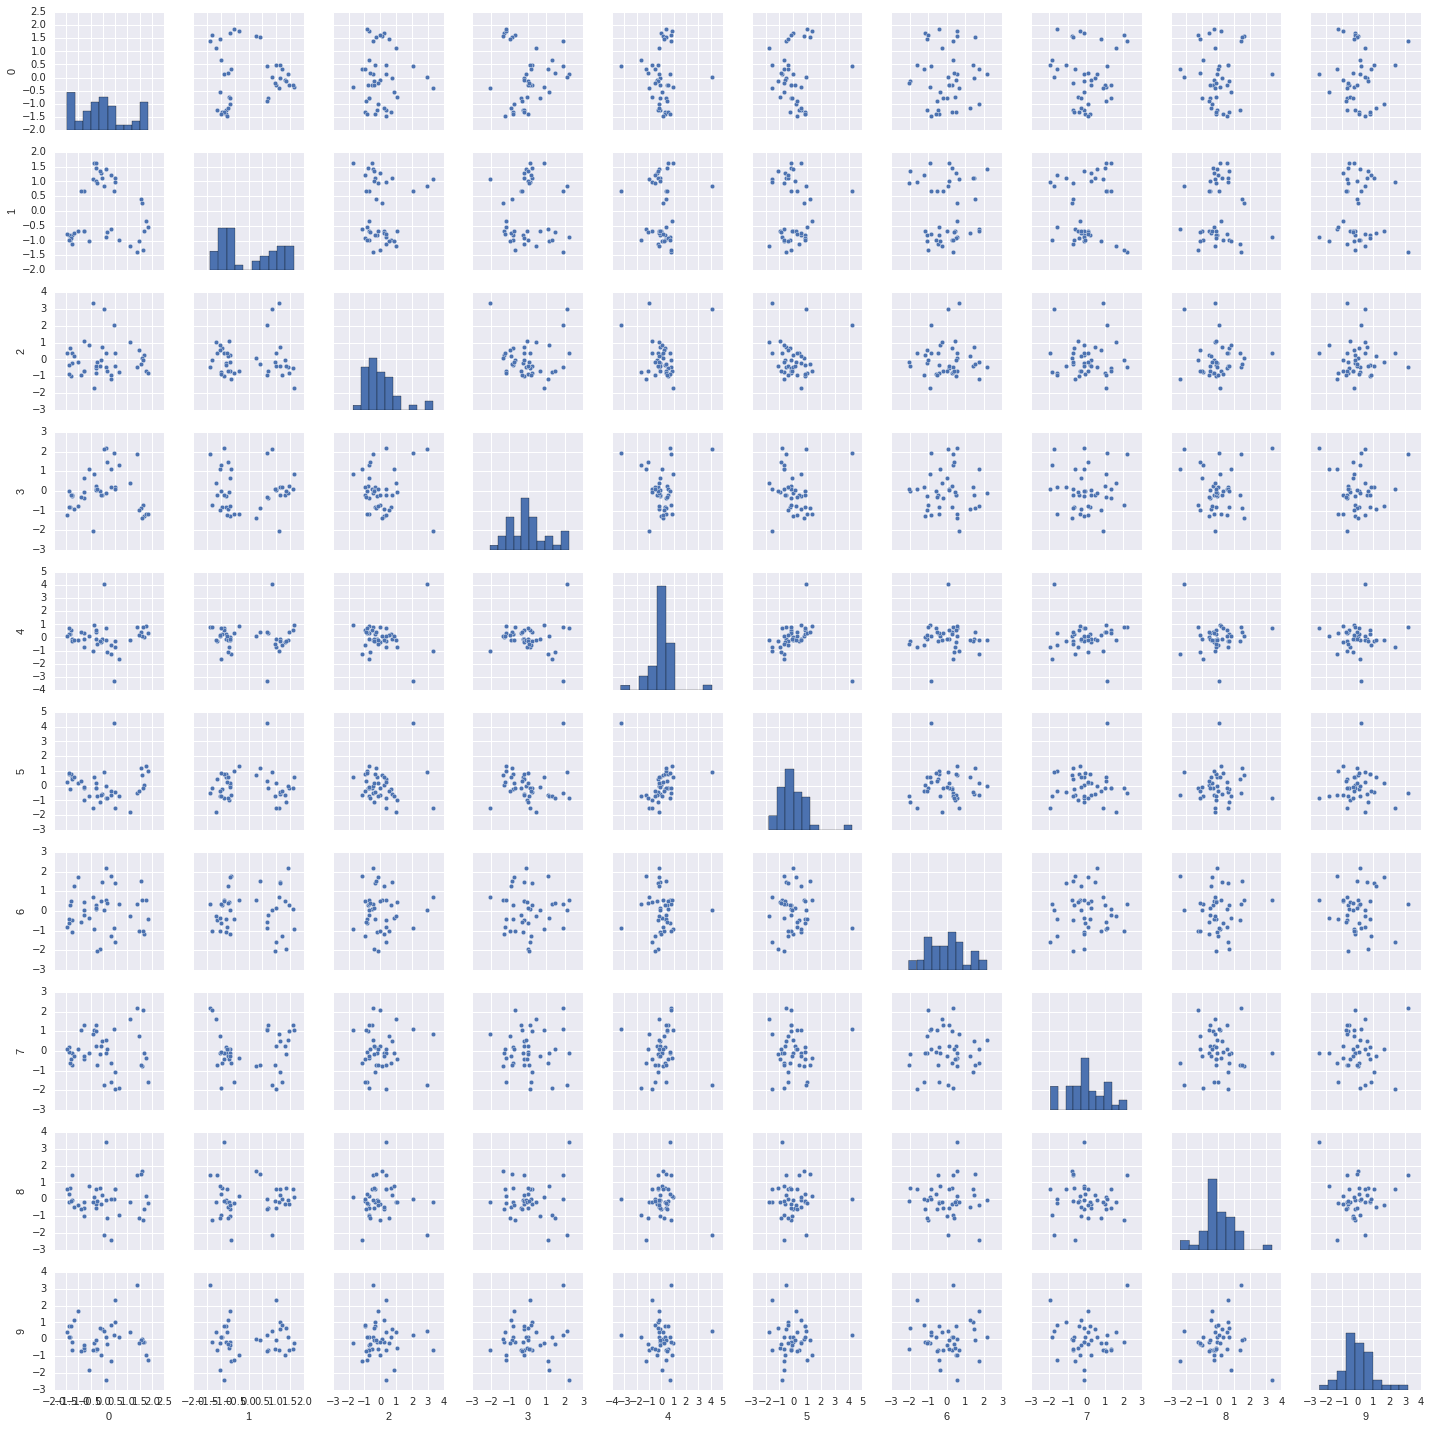

In [159]:
#fmri data
df = pd.DataFrame(T1_data_reduced)
sns.pairplot(df,size = 2, aspect=1)

## PErform CCA

In [102]:
cca = ml_cca.MaximumLikelihoodCCA(8,reg = 100000000)

It seems like regularisation doesn't make much of a difference as the dimensionality of the problem has already been reduced through PCA

In [103]:
cca.fit(fMRI_data_reduced,T1_data_reduced)

Training CCA, regularization = 100000000.0000, 8 components


In [104]:
cca.transform()

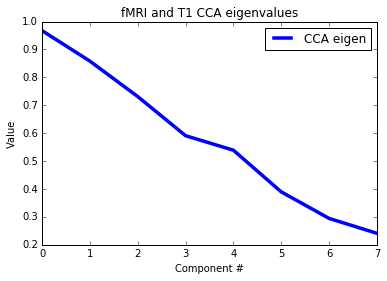

In [106]:
line1, = plt.plot(cca.Pd,'b',label = 'CCA eigen',linewidth = 3.5)
plt.title('fMRI and T1 CCA eigenvalues')
plt.xlabel('Component #')
plt.ylabel('Value')
plt.legend(handles=[line1])

# Reconstruct the image

Lets see if we can reconstruct the T1 image from a slice of a persons fMRI. the fMRI has poor resolution so hopefully we should get a better resolution image.

In [167]:
# We first reduce the dimensionality of the fmri
reduced_fmri_test = fmri_pca.transform(fMRI_data_test.reshape(1,-1))

In [168]:
reconstructed_T1_mean = cca.predict_Y_given_X(reduced_fmri_test)

In [169]:
reconstruct_original_T1 = T1_pca.inverse_transform(reconstructed_T1_mean)

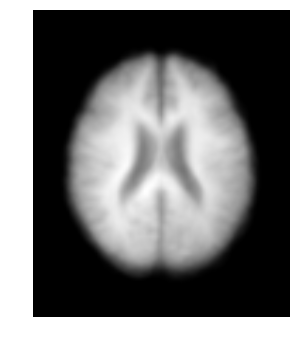

In [170]:
plt.imshow(np.rot90(reconstruct_original_T1[0].reshape((91,109,91))[:,:,50]), 
               cmap="gray")
plt.gca().set_axis_off()

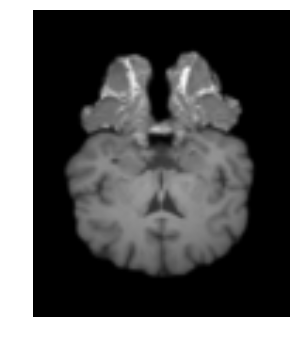

In [176]:
plt.imshow(np.rot90(T1_data_test.reshape((91,109,91))[:,:,50]), 
               cmap="gray")
plt.gca().set_axis_off()

Ok so that didn't work too well. Let try reconstructing the fMRI slice from T1

In [177]:
reduced_T1_test = T1_pca.transform(T1_data_test.reshape(1,-1))

In [178]:
reconstructed_fMRI_mean = cca.predict_X_given_Y(reduced_T1_test)
reconstruct_original_fmri = fmri_pca.inverse_transform(reconstructed_fMRI_mean)

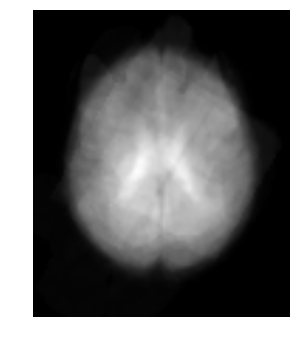

In [179]:
plt.imshow(np.rot90(reconstruct_original_fmri[0].reshape((91,109,91))[:,:,50]), 
               cmap="gray")
plt.gca().set_axis_off()

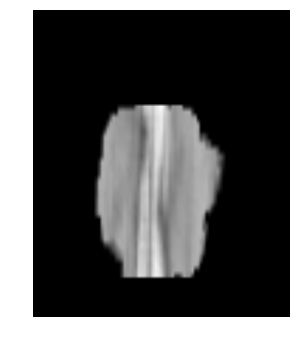

In [182]:
plt.imshow(np.rot90(fMRI_data_test.reshape((91,109,91))[:,:,50]), 
               cmap="gray")
plt.gca().set_axis_off()

Hmmmmm.....